In [1]:
import argparse
import os
import pathlib
import sys
import numpy as np
import torch
import imageio
import util
import bayes3d as b
from tqdm import tqdm

import nvdiffrast.torch as dr

#----------------------------------------------------------------------------
# Quaternion math.
#----------------------------------------------------------------------------

# Unit quaternion.
def q_unit():
    return np.asarray([1, 0, 0, 0], np.float32)

# Get a random normalized quaternion.
def q_rnd():
    u, v, w = np.random.uniform(0.0, 1.0, size=[3])
    v *= 2.0 * np.pi
    w *= 2.0 * np.pi
    return np.asarray([(1.0-u)**0.5 * np.sin(v), (1.0-u)**0.5 * np.cos(v), u**0.5 * np.sin(w), u**0.5 * np.cos(w)], np.float32)

# Get a random quaternion from the octahedral symmetric group S_4.
_r2 = 0.5**0.5
_q_S4 = [[ 1.0, 0.0, 0.0, 0.0], [ 0.0, 1.0, 0.0, 0.0], [ 0.0, 0.0, 1.0, 0.0], [ 0.0, 0.0, 0.0, 1.0],
         [-0.5, 0.5, 0.5, 0.5], [-0.5,-0.5,-0.5, 0.5], [ 0.5,-0.5, 0.5, 0.5], [ 0.5, 0.5,-0.5, 0.5],
         [ 0.5, 0.5, 0.5, 0.5], [-0.5, 0.5,-0.5, 0.5], [ 0.5,-0.5,-0.5, 0.5], [-0.5,-0.5, 0.5, 0.5],
         [ _r2,-_r2, 0.0, 0.0], [ _r2, _r2, 0.0, 0.0], [ 0.0, 0.0, _r2, _r2], [ 0.0, 0.0,-_r2, _r2],
         [ 0.0, _r2, _r2, 0.0], [ _r2, 0.0, 0.0,-_r2], [ _r2, 0.0, 0.0, _r2], [ 0.0,-_r2, _r2, 0.0],
         [ _r2, 0.0, _r2, 0.0], [ 0.0, _r2, 0.0, _r2], [ _r2, 0.0,-_r2, 0.0], [ 0.0,-_r2, 0.0, _r2]]
def q_rnd_S4():
    return np.asarray(_q_S4[np.random.randint(24)], np.float32)

# Quaternion slerp.
def q_slerp(p, q, t):
    d = np.dot(p, q)
    if d < 0.0:
        q = -q
        d = -d
    if d > 0.999:
        a = p + t * (q-p)
        return a / np.linalg.norm(a)
    t0 = np.arccos(d)
    tt = t0 * t
    st = np.sin(tt)
    st0 = np.sin(t0)
    s1 = st / st0
    s0 = np.cos(tt) - d*s1
    return s0*p + s1*q

# Quaterion scale (slerp vs. identity quaternion).
def q_scale(q, scl):
    return q_slerp(q_unit(), q, scl)

# Quaternion product.
def q_mul(p, q):
    s1, V1 = p[0], p[1:]
    s2, V2 = q[0], q[1:]
    s = s1*s2 - np.dot(V1, V2)
    V = s1*V2 + s2*V1 + np.cross(V1, V2)
    return np.asarray([s, V[0], V[1], V[2]], np.float32)

# Angular difference between two quaternions in degrees.
def q_angle_deg(p, q):
    p = p.detach().cpu().numpy()
    q = q.detach().cpu().numpy()
    d = np.abs(np.dot(p, q))
    d = min(d, 1.0)
    return np.degrees(2.0 * np.arccos(d))

# Quaternion product
def q_mul_torch(p, q):
    a = p[0]*q[0] - p[1]*q[1] - p[2]*q[2] - p[3]*q[3]
    b = p[0]*q[1] + p[1]*q[0] + p[2]*q[3] - p[3]*q[2]
    c = p[0]*q[2] + p[2]*q[0] + p[3]*q[1] - p[1]*q[3]
    d = p[0]*q[3] + p[3]*q[0] + p[1]*q[2] - p[2]*q[1]
    return torch.stack([a, b, c, d])

# Convert quaternion to 4x4 rotation matrix.
def q_to_mtx(q):
    r0 = torch.stack([1.0-2.0*q[1]**2 - 2.0*q[2]**2, 2.0*q[0]*q[1] - 2.0*q[2]*q[3], 2.0*q[0]*q[2] + 2.0*q[1]*q[3]])
    r1 = torch.stack([2.0*q[0]*q[1] + 2.0*q[2]*q[3], 1.0 - 2.0*q[0]**2 - 2.0*q[2]**2, 2.0*q[1]*q[2] - 2.0*q[0]*q[3]])
    r2 = torch.stack([2.0*q[0]*q[2] - 2.0*q[1]*q[3], 2.0*q[1]*q[2] + 2.0*q[0]*q[3], 1.0 - 2.0*q[0]**2 - 2.0*q[1]**2])
    rr = torch.transpose(torch.stack([r0, r1, r2]), 1, 0)
    rr = torch.cat([rr, torch.tensor([[0], [0], [0]], dtype=torch.float32).cuda()], dim=1) # Pad right column.
    rr = torch.cat([rr, torch.tensor([[0, 0, 0, 1]], dtype=torch.float32).cuda()], dim=0)  # Pad bottom row.
    return rr

# Transform vertex positions to clip space
def transform_pos(mtx, pos):
    t_mtx = torch.from_numpy(mtx).cuda() if isinstance(mtx, np.ndarray) else mtx
    # (x,y,z) -> (x,y,z,1)
    posw = torch.cat([pos, torch.ones([pos.shape[0], 1]).cuda()], axis=1)
    return torch.matmul(posw, t_mtx.t())[None, ...]

def render(glctx, mtx, pos, pos_idx, col, col_idx, resolution: int):
    # Setup TF graph for reference.
    pos_clip    = transform_pos(mtx, pos)
    rast_out, _ = dr.rasterize(glctx, pos_clip, pos_idx, resolution=[resolution, resolution])
    color   , _ = dr.interpolate(col[None, ...], rast_out, col_idx)
    color       = dr.antialias(color, rast_out, pos_clip, pos_idx)
    return color
    # return rast_out[:,:,:,2:3]


In [32]:
datadir = "/home/nishadgothoskar/bayes3d/nvdiffrast/samples/data/"
with np.load(f'{datadir}/cube_p.npz') as f:
    pos_idx, pos, col_idx, col = f.values()
print("Mesh has %d triangles and %d vertices." % (pos_idx.shape[0], pos.shape[0]))

# Some input geometry contains vertex positions in (N, 4) (with v[:,3]==1).  Drop
# the last column in that case.
if pos.shape[1] == 4: pos = pos[:, 0:3]

# Create position/triangle index tensors
pos_idx = torch.from_numpy(pos_idx.astype(np.int32)).cuda()
vtx_pos = torch.from_numpy(pos.astype(np.float32)).cuda()
col_idx = torch.from_numpy(col_idx.astype(np.int32)).cuda()
vtx_col = torch.from_numpy(col.astype(np.float32)).cuda()
print(pos_idx.shape, vtx_pos.shape, col_idx.shape, vtx_col.shape)
print(vtx_col)

Mesh has 12 triangles and 24 vertices.
torch.Size([12, 3]) torch.Size([24, 3]) torch.Size([12, 3]) torch.Size([6, 3])
tensor([[1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.6470, 0.0000]], device='cuda:0')


In [3]:
# model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
# idx = 14
# mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
# m = b.utils.load_mesh(mesh_path)
# m = b.utils.scale_mesh(m, 1.0/100.0)

In [4]:
# vtx_pos = torch.from_numpy(m.vertices.astype(np.float32)).cuda()
# pos_idx = torch.from_numpy(m.faces.astype(np.int32)).cuda()
# col_idx = torch.from_numpy(np.zeros((vtx_pos.shape[0],3)).astype(np.int32)).cuda()
# vtx_col = torch.from_numpy(np.ones((1,3)).astype(np.float32)).cuda()

In [33]:
max_iter           = 10000
repeats            = 1
log_interval       = 10
display_interval   = None
display_res        = 512
lr_base            = 0.01
lr_falloff         = 1.0
nr_base            = 1.0
nr_falloff         = 1e-4
grad_phase_start   = 0.5
resolution         = 256
out_dir            = None
log_fn             = None
mp4save_interval   = None
mp4save_fn         = None
use_opengl         = False

In [7]:
glctx = dr.RasterizeGLContext() #if use_opengl else dr.RasterizeCudaContext()
mvp = torch.tensor(np.matmul(util.projection(x=0.4), util.translate(0, 0, -3.5)).astype(np.float32), device='cuda')


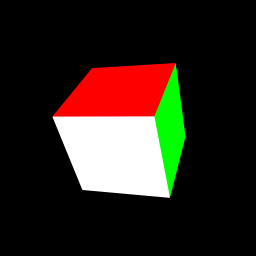

In [43]:
pose_target = torch.tensor(q_rnd(), device='cuda')
rast_target = render(glctx, torch.matmul(mvp, q_to_mtx(pose_target)), vtx_pos, pos_idx, vtx_col, col_idx, resolution)
img_target  = rast_target[0].detach().cpu().numpy()
b.hstack_images([
    b.get_rgb_image(img_target[:,:]* 255.0) ,
])


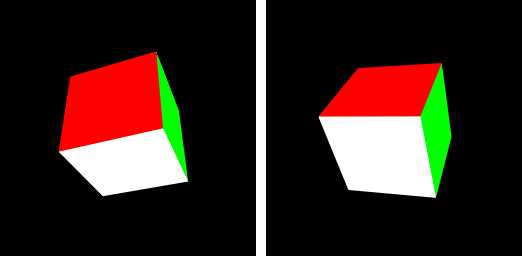

In [51]:
pose_init   = pose_target.cpu().numpy() + 0.1
pose_opt    = torch.tensor(pose_init / np.sum(pose_init**2)**0.5, dtype=torch.float32, device='cuda', requires_grad=True)
loss_best   = np.inf

rast_opt = render(glctx, torch.matmul(mvp, q_to_mtx(pose_opt)), vtx_pos, pos_idx, vtx_col, col_idx, resolution)
img_opt  = rast_opt[0].detach().cpu().numpy()
b.hstack_images([
    b.get_rgb_image(img_opt[:,:]* 255.0) ,
    b.get_rgb_image(img_target[:,:]* 255.0) ,
])


In [52]:
optimizer = torch.optim.Adam([pose_opt], betas=(0.9, 0.999), lr=lr_base)

In [53]:
images = []

In [54]:
for _ in tqdm(range(200)):
    noise = q_unit()
    pose_total_opt = q_mul_torch(pose_opt, noise)
    mtx_total_opt  = torch.matmul(mvp, q_to_mtx(pose_total_opt))
    color_opt      = render(glctx, mtx_total_opt, vtx_pos, pos_idx, vtx_col, col_idx, resolution)
    
    diff = (rast_opt - rast_target)**2 # L2 norm.
    diff = torch.tanh(5.0 * torch.max(diff, dim=-1)[0])
    loss = torch.mean(diff)
    loss_val = float(loss)
    
    if (loss_val < loss_best) and (loss_val > 0.0):
        loss_best = loss_val
                
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(pose_opt.grad)
    
    with torch.no_grad():
        pose_opt /= torch.sum(pose_opt**2)**0.5
    
    rast_opt = render(glctx, torch.matmul(mvp, q_to_mtx(pose_opt)), vtx_pos, pos_idx, vtx_col, col_idx, resolution)
    img_opt  = rast_opt[0].detach().cpu().numpy()
    images.append(b.hstack_images([
        b.get_rgb_image(img_opt[:,:]* 255.0) ,
        b.get_rgb_image(img_target[:,:]* 255.0) ,
    ]))

 10%|███████████████████▏                                                                                                                                                                   | 21/200 [00:00<00:01, 99.65it/s]

tensor([0.1530, 0.0901, 0.2134, 0.1756], device='cuda:0')
tensor([0.0735, 0.1006, 0.1931, 0.2305], device='cuda:0')
tensor([0.1007, 0.2316, 0.1641, 0.2277], device='cuda:0')
tensor([0.1189, 0.1390, 0.2813, 0.2347], device='cuda:0')
tensor([0.0861, 0.1937, 0.2408, 0.2476], device='cuda:0')
tensor([0.1285, 0.1648, 0.2848, 0.2397], device='cuda:0')
tensor([0.1305, 0.2032, 0.2868, 0.2418], device='cuda:0')
tensor([0.0333, 0.2472, 0.2918, 0.2774], device='cuda:0')
tensor([0.2317, 0.2620, 0.3460, 0.2262], device='cuda:0')
tensor([0.1532, 0.2795, 0.3406, 0.2767], device='cuda:0')
tensor([0.1442, 0.5875, 0.2516, 0.3313], device='cuda:0')
tensor([-0.0614, -0.3087, -0.4299, -0.3053], device='cuda:0')
tensor([-0.1657, -0.2562, -0.3900, -0.2941], device='cuda:0')
tensor([-0.1305, -0.2318, -0.3477, -0.3084], device='cuda:0')
tensor([-0.1320, -0.2678, -0.3546, -0.3496], device='cuda:0')
tensor([-0.1381, -0.2952, -0.3482, -0.3410], device='cuda:0')
tensor([-0.1417, -0.2903, -0.3563, -0.3355], device=

 16%|█████████████████████████████                                                                                                                                                         | 32/200 [00:00<00:01, 100.21it/s]

tensor([-0.2130, -0.3029,  0.5378, -0.3065], device='cuda:0')
tensor([0.1586, 0.4555, 0.3889, 0.3307], device='cuda:0')
tensor([0.1145, 0.5267, 0.0742, 0.2876], device='cuda:0')
tensor([0.1405, 0.4443, 0.0066, 0.3064], device='cuda:0')
tensor([ 0.1146,  0.4685, -0.0074,  0.2999], device='cuda:0')
tensor([ 0.0987,  0.4552, -0.0298,  0.2731], device='cuda:0')
tensor([0.2246, 0.4968, 0.0077, 0.3142], device='cuda:0')
tensor([0.4643, 0.4258, 0.0720, 0.3949], device='cuda:0')
tensor([0.0474, 0.2067, 0.0675, 0.4056], device='cuda:0')
tensor([ 0.1708, -0.8076, -0.0729,  0.1670], device='cuda:0')
tensor([-0.3641, -0.6680, -0.0216, -0.3605], device='cuda:0')
tensor([ 0.0669, -0.5937,  0.0939, -0.1923], device='cuda:0')
tensor([-0.5864, -0.4802, -0.0967, -0.5270], device='cuda:0')
tensor([-0.3134, -0.0711,  0.0346, -0.4813], device='cuda:0')
tensor([-0.2505,  0.2483, -0.0113, -0.4001], device='cuda:0')
tensor([-0.4118,  0.6334, -0.2129, -0.3573], device='cuda:0')
tensor([ 0.4603,  0.7349, -0.038

 27%|█████████████████████████████████████████████████▏                                                                                                                                    | 54/200 [00:00<00:01, 101.91it/s]

tensor([-0.2743, -0.6656,  0.1880, -0.4085], device='cuda:0')
tensor([-0.1904, -0.3107,  0.0079, -0.3906], device='cuda:0')
tensor([-0.4775,  0.4947, -0.3051, -0.3210], device='cuda:0')
tensor([ 0.2254,  0.8278, -0.0499,  0.1708], device='cuda:0')
tensor([ 0.4327,  0.7410, -0.0750,  0.4210], device='cuda:0')
tensor([0.5770, 0.4783, 0.1180, 0.4922], device='cuda:0')
tensor([-0.3147, -0.6692,  0.0991, -0.3258], device='cuda:0')
tensor([-0.4296, -0.7884,  0.0153, -0.4195], device='cuda:0')
tensor([-0.3299, -0.8079, -0.0759, -0.3092], device='cuda:0')
tensor([ 4.8362e-01, -3.8319e-04,  3.0022e-02,  3.7322e-01], device='cuda:0')
tensor([0.4659, 0.6768, 0.0468, 0.4294], device='cuda:0')
tensor([-2.7014e-02,  8.2175e-01,  6.6018e-04,  2.5257e-02], device='cuda:0')
tensor([-0.6162,  0.3493, -0.1624, -0.4157], device='cuda:0')
tensor([-0.3802, -0.3864, -0.0202, -0.3420], device='cuda:0')
tensor([ 0.4007, -0.6211,  0.1533,  0.2227], device='cuda:0')
tensor([ 0.5897, -0.4337,  0.1063,  0.4055], d

 38%|█████████████████████████████████████████████████████████████████████▏                                                                                                                | 76/200 [00:00<00:01, 103.13it/s]

tensor([ 0.2207, -0.5094, -0.0869,  0.1266], device='cuda:0')
tensor([-0.2453, -0.3171,  0.0615, -0.2419], device='cuda:0')
tensor([-0.3043,  0.1831,  0.1181, -0.2309], device='cuda:0')
tensor([ 0.0479,  0.4702, -0.0427,  0.0922], device='cuda:0')
tensor([ 0.2338,  0.3200, -0.1556,  0.2435], device='cuda:0')
tensor([ 0.0689, -0.1134,  0.0094,  0.0381], device='cuda:0')
tensor([-0.1631, -0.4117,  0.1498, -0.2019], device='cuda:0')
tensor([-0.1098, -0.3063,  0.0221, -0.1296], device='cuda:0')
tensor([ 0.1304,  0.0821, -0.1098,  0.1289], device='cuda:0')
tensor([ 0.1701,  0.3581, -0.0194,  0.1727], device='cuda:0')
tensor([-0.0804,  0.2594,  0.0651, -0.0421], device='cuda:0')
tensor([-0.2267, -0.0756, -0.0052, -0.1855], device='cuda:0')
tensor([-0.0095, -0.2860, -0.0417, -0.0407], device='cuda:0')
tensor([ 0.2439, -0.2031,  0.0392,  0.1571], device='cuda:0')
tensor([0.1319, 0.0506, 0.0302, 0.1040], device='cuda:0')
tensor([-0.1781,  0.2106, -0.0565, -0.1037], device='cuda:0')
tensor([-0.2

 49%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 98/200 [00:00<00:00, 102.28it/s]

tensor([-0.1007,  0.1706,  0.0293, -0.0626], device='cuda:0')
tensor([ 0.0590,  0.1538, -0.0449,  0.0720], device='cuda:0')
tensor([ 0.0984, -0.0169, -0.0278,  0.0779], device='cuda:0')
tensor([-0.0181, -0.1595,  0.0441, -0.0395], device='cuda:0')
tensor([-0.0780, -0.1316,  0.0260, -0.0797], device='cuda:0')
tensor([ 0.0062,  0.0370, -0.0354,  0.0151], device='cuda:0')
tensor([ 0.0714,  0.1527, -0.0129,  0.0764], device='cuda:0')
tensor([-0.0045,  0.0940,  0.0196,  0.0050], device='cuda:0')
tensor([-0.0831, -0.0614, -0.0040, -0.0712], device='cuda:0')
tensor([-0.0084, -0.1268, -0.0058, -0.0218], device='cuda:0')
tensor([ 0.0933, -0.0501,  0.0183,  0.0631], device='cuda:0')
tensor([ 0.0339,  0.0613, -0.0052,  0.0350], device='cuda:0')
tensor([-0.0831,  0.0932, -0.0225, -0.0495], device='cuda:0')
tensor([-0.0603,  0.0327,  0.0144, -0.0448], device='cuda:0')
tensor([ 0.0542, -0.0539,  0.0133,  0.0332], device='cuda:0')
tensor([ 0.0715, -0.0800, -0.0188,  0.0485], device='cuda:0')
tensor([

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 120/200 [00:01<00:00, 103.37it/s]

tensor([-0.0147,  0.0168, -0.0140, -0.0070], device='cuda:0')
tensor([0.0302, 0.0668, 0.0007, 0.0319], device='cuda:0')
tensor([0.0071, 0.0323, 0.0027, 0.0090], device='cuda:0')
tensor([-0.0327, -0.0381, -0.0058, -0.0289], device='cuda:0')
tensor([-0.0027, -0.0524,  0.0077, -0.0097], device='cuda:0')
tensor([ 0.0352, -0.0052,  0.0046,  0.0261], device='cuda:0')
tensor([ 0.0058,  0.0392, -0.0121,  0.0113], device='cuda:0')
tensor([-0.0355,  0.0340, -0.0002, -0.0231], device='cuda:0')
tensor([-0.0135, -0.0073,  0.0109, -0.0130], device='cuda:0')
tensor([ 0.0297, -0.0358, -0.0068,  0.0198], device='cuda:0')
tensor([ 0.0212, -0.0212, -0.0033,  0.0145], device='cuda:0')
tensor([-0.0220,  0.0157,  0.0093, -0.0165], device='cuda:0')
tensor([-0.0249,  0.0312, -0.0045, -0.0145], device='cuda:0')
tensor([ 0.0147,  0.0107, -0.0057,  0.0137], device='cuda:0')
tensor([ 0.0220, -0.0215,  0.0061,  0.0136], device='cuda:0')
tensor([-0.0107, -0.0278,  0.0009, -0.0116], device='cuda:0')
tensor([-0.0158,

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 142/200 [00:01<00:00, 103.89it/s]

tensor([ 0.0051,  0.0190, -0.0051,  0.0072], device='cuda:0')
tensor([-0.0135,  0.0135,  0.0040, -0.0094], device='cuda:0')
tensor([-0.0072, -0.0077,  0.0006, -0.0065], device='cuda:0')
tensor([ 0.0138, -0.0163, -0.0029,  0.0092], device='cuda:0')
tensor([ 0.0085, -0.0042,  0.0028,  0.0058], device='cuda:0')
tensor([-0.0131,  0.0106, -0.0004, -0.0086], device='cuda:0')
tensor([-0.0086,  0.0119, -0.0022, -0.0048], device='cuda:0')
tensor([ 0.0107, -0.0010,  0.0019,  0.0079], device='cuda:0')
tensor([ 0.0063, -0.0130, -0.0006,  0.0036], device='cuda:0')
tensor([-0.0081, -0.0074, -0.0003, -0.0070], device='cuda:0')
tensor([-0.0038,  0.0084,  0.0022, -0.0022], device='cuda:0')
tensor([ 0.0057,  0.0116, -0.0025,  0.0063], device='cuda:0')
tensor([ 0.0013, -0.0010, -0.0012,  0.0011], device='cuda:0')
tensor([-0.0051, -0.0112,  0.0037, -0.0058], device='cuda:0')
tensor([ 0.0007, -0.0053, -0.0014,  0.0002], device='cuda:0')
tensor([ 0.0055,  0.0072, -0.0012,  0.0054], device='cuda:0')
tensor([

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 164/200 [00:01<00:00, 104.19it/s]

tensor([ 3.5361e-03, -3.9073e-04,  1.3448e-05,  2.7856e-03], device='cuda:0')
tensor([ 0.0041, -0.0059, -0.0012,  0.0028], device='cuda:0')
tensor([-0.0029, -0.0030,  0.0018, -0.0029], device='cuda:0')
tensor([-0.0032,  0.0039, -0.0005, -0.0017], device='cuda:0')
tensor([ 0.0027,  0.0051, -0.0012,  0.0030], device='cuda:0')
tensor([ 0.0012, -0.0011,  0.0009,  0.0008], device='cuda:0')
tensor([-2.8819e-03, -5.4928e-03, -8.9666e-05, -2.8450e-03], device='cuda:0')
tensor([ 4.4251e-04, -1.3023e-03,  6.2984e-05,  2.7977e-04], device='cuda:0')
tensor([0.0026, 0.0042, 0.0001, 0.0026], device='cuda:0')
tensor([-0.0020,  0.0029, -0.0009, -0.0011], device='cuda:0')
tensor([-0.0023, -0.0020,  0.0009, -0.0021], device='cuda:0')
tensor([ 0.0026, -0.0034,  0.0001,  0.0017], device='cuda:0')
tensor([ 1.6754e-03, -8.7319e-05, -8.2074e-04,  1.5397e-03], device='cuda:0')
tensor([-0.0028,  0.0029,  0.0008, -0.0018], device='cuda:0')
tensor([-0.0016,  0.0017, -0.0005, -0.0009], device='cuda:0')
tensor([ 0

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 186/200 [00:01<00:00, 103.80it/s]

tensor([ 0.0010,  0.0013, -0.0006,  0.0011], device='cuda:0')
tensor([3.1434e-05, 2.0331e-03, 6.7627e-05, 3.2311e-04], device='cuda:0')
tensor([-0.0016, -0.0003,  0.0002, -0.0011], device='cuda:0')
tensor([ 0.0004, -0.0018, -0.0002,  0.0003], device='cuda:0')
tensor([ 0.0014, -0.0004,  0.0003,  0.0011], device='cuda:0')
tensor([-0.0013,  0.0012, -0.0004, -0.0006], device='cuda:0')
tensor([-0.0011,  0.0011,  0.0002, -0.0007], device='cuda:0')
tensor([ 1.2119e-03, -5.5246e-04, -6.0484e-05,  8.7237e-04], device='cuda:0')
tensor([ 0.0004, -0.0013, -0.0002,  0.0003], device='cuda:0')
tensor([-9.8535e-04, -3.6158e-05,  5.4830e-04, -7.8220e-04], device='cuda:0')
tensor([-0.0004,  0.0012, -0.0006,  0.0001], device='cuda:0')
tensor([0.0007, 0.0006, 0.0003, 0.0007], device='cuda:0')
tensor([-4.1413e-04, -1.0492e-03, -5.9816e-05, -3.6619e-04], device='cuda:0')
tensor([-5.5916e-04, -8.3893e-04, -7.8104e-05, -3.7295e-04], device='cuda:0')
tensor([0.0005, 0.0007, 0.0003, 0.0007], device='cuda:0')
te

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 102.45it/s]

tensor([ 0.0006, -0.0003,  0.0002,  0.0006], device='cuda:0')
tensor([-7.2778e-06, -6.0561e-04, -2.2359e-04, -1.1634e-05], device='cuda:0')
tensor([-0.0006,  0.0002,  0.0002, -0.0004], device='cuda:0')
tensor([2.2357e-04, 6.5441e-04, 8.1254e-06, 2.3421e-04], device='cuda:0')
tensor([ 7.3216e-05,  2.6170e-05, -3.2215e-04,  2.4398e-04], device='cuda:0')
tensor([-0.0004, -0.0005,  0.0005, -0.0002], device='cuda:0')
tensor([-1.0865e-05, -2.3696e-04, -3.9120e-04,  9.2040e-06], device='cuda:0')


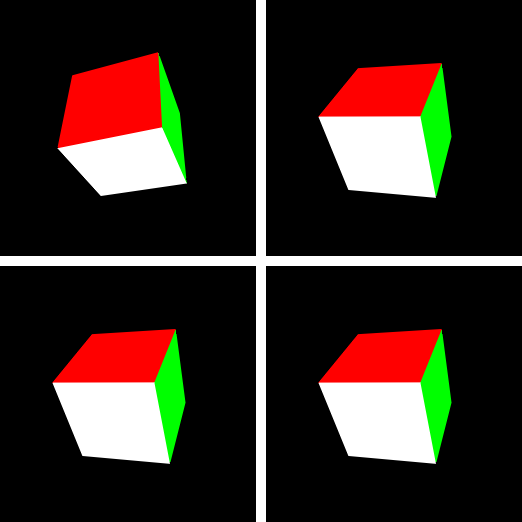

In [56]:
b.vstack_images([images[0],images[-1]])

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

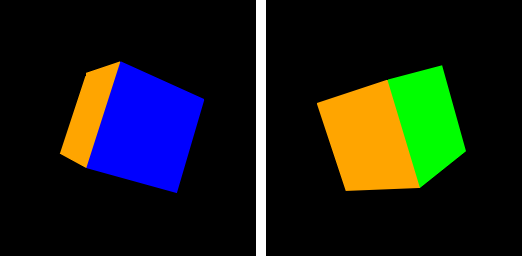